# Poisson Point Process for a Blob Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import tinyDA as tda

In [2]:
np.random.seed(456)

### Defining the prior and proposal

In [3]:
class PoissonPointProcess:

    def __init__(self, lamb, domain, attributes={}):
        
        self.lamb = lamb
        self.domain = domain
        self.attributes = attributes
        
        self.pois = stats.poisson(lamb)
        
        self.domain_dist = stats.uniform(loc=self.domain[:,0],
                                         scale=self.domain[:,1]-self.domain[:,0])
    
    def logpdf(self, x):
        return self.pois.logpmf(len(x))
    
    def rvs(self):
        
        k = self.pois.rvs()
        
        return [self.create_point() for i in range(k)]
    
    def create_point(self):
        point = {'position': self.domain_dist.rvs()}
        for attr, dist in self.attributes.items():
            point[attr] = dist.rvs()
        return point

In [4]:
from random import sample
from copy import deepcopy

class PoissonPointProposal(tda.GaussianRandomWalk):

    is_symmetric = True

    def __init__(self, move_distribution={'create': 0.2, 
                                          'destroy': 0.2,
                                          'shuffle': 0.2,
                                          'swap': 0.2,
                                          'perturb': 0.2}):
        
        self.move_distribution = move_distribution
        
        self.moves = [self.__getattribute__(move) for move in self.move_distribution.keys()]
        self.probabilities = np.array([p for p in self.move_distribution.values()]).astype(float)
        self.probabilities /= self.probabilities.sum()

    def setup_proposal(self, **kwargs):
        self.prior = kwargs["posterior"].prior
        pass

    def adapt(self, **kwargs):
        pass

    def make_proposal(self, link):
        while True:
            try:
                move = np.random.choice(self.moves, p=self.probabilities)
                proposal = move(link.parameters)
                if not self.is_feasible(proposal):
                    continue
            except ValueError:
                continue
            
            return proposal
    
    def is_feasible(self, proposal):
        return True
    
    def create(self, x):
        y = deepcopy(x)
        idx = np.random.choice(range(len(x)+1))
        y.insert(idx, self.prior.create_point())
        return y
    
    def destroy(self, x):
        y = deepcopy(x)
        idx = np.random.choice(range(len(x)))
        del y[idx]
        return y
    
    def shuffle(self, x):
        return sample(x, len(x))
    
    def swap(self, x):
        y = deepcopy(x)
        idx, idy = np.random.choice(range(len(x)), size=2, replace=False)
        y[idy], y[idx] = x[idx], x[idy]
        return y
    
    def perturb(self, x):
        y = deepcopy(x)
        idx = np.random.choice(range(len(x)))
        attr = np.random.choice(list(self.prior.attributes.keys()))
        y[idx][attr] = self.prior.attributes[attr].rvs()
        return y

### Set up the model

In [5]:
domain = np.array([[0,2], [0,1]])
prior_lamb = 6
prior_attr = {'radius': stats.uniform(scale=0.2)}

my_prior = PoissonPointProcess(prior_lamb, domain, prior_attr)

parameters_true = my_prior.rvs()

In [6]:
class BlobModel:
    def __init__(self, domain=np.array([[0,1], [0,1]]), resolution=(51,51)):
        
        self.domain = domain
        self.resolution = resolution
        
        self.x = np.linspace(*self.domain[0,:], resolution[0])
        self.y = np.linspace(*self.domain[1,:], resolution[1])
        self.X, self.Y = np.meshgrid(self.x, self.y)
        
    def __call__(self, parameters):
        
        Z = np.zeros(self.X.shape)
        
        for point in parameters:
            radius = np.sqrt((self.X - point['position'][0])**2 + (self.Y - point['position'][1])**2)
            Z += radius < point['radius']
            
        return Z.astype(bool).astype(float).flatten()

In [7]:
my_model = BlobModel(domain, resolution=(201,101))

In [8]:
sigma = 0.05

data_pure = my_model(parameters_true)
data = data_pure + np.random.normal(scale=sigma, size=data_pure.size)

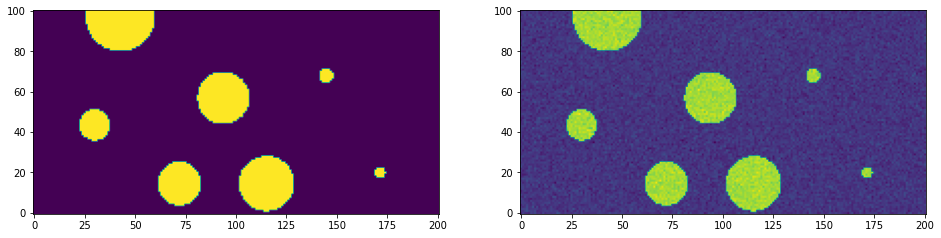

In [9]:
fig, ax = plt.subplots(figsize=(16,4), nrows=1, ncols=2)
ax[0].imshow(data_pure.reshape(my_model.X.shape), origin='lower')
ax[1].imshow(data.reshape(my_model.X.shape), origin='lower')

### Set up the likelihood

In [10]:
# set the likelihood
cov_likelihood = sigma**2*np.eye(data.size)
my_loglike = tda.GaussianLogLike(data, cov_likelihood)

In [11]:
# initialise the LinkFactory
my_posterior = tda.Posterior(my_prior, my_loglike, my_model)

### Set up the proposal

In [12]:
my_proposal = PoissonPointProposal(move_distribution={'create': 1, 
                                                      'destroy': 1,
                                                      'shuffle': 0,
                                                      'swap': 0,
                                                      'perturb': 1})

### Sample

In [13]:
my_chains = tda.sample(my_posterior, my_proposal, iterations=120000, n_chains=2, force_sequential=True)

Sampling chain 1/2


Running chain, α = 0.50:   0%|                       | 0/120000 [00:00<?, ?it/s]/home/mikkel/venv/tinyda/lib/python3.8/site-packages/tinyDA/proposal.py:239: RuntimeWarning: overflow encountered in exp
  return np.exp(proposal_link.posterior - previous_link.posterior)
Running chain, α = 0.01: 100%|█████████| 120000/120000 [16:24<00:00, 121.93it/s]


Sampling chain 2/2


Running chain, α = 0.00: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [15:24<00:00, 129.82it/s]


### Get some diagnostics

In [28]:
def get_mean_and_variance(chain, burnin):
    samples = np.array([link.model_output.reshape(my_model.X.shape) for link in chain[burnin:]])
    return samples.mean(axis=0), samples.var(axis=0)

In [29]:
burnin = 20000

chain_0_mean, chain_0_var = get_mean_and_variance(my_chains['chain_0'], burnin)
chain_1_mean, chain_1_var = get_mean_and_variance(my_chains['chain_1'], burnin)

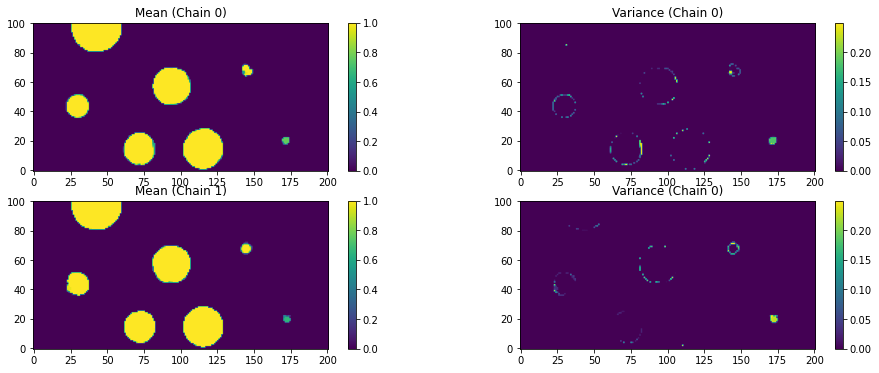

In [30]:
fig, ax = plt.subplots(figsize=(16,6), nrows=2, ncols=2)

ax[0,0].set_title('Mean (Chain 0)')
p_m_0 = ax[0,0].imshow(chain_0_mean, origin='lower')
plt.colorbar(p_m_0, ax=ax[0,0])

ax[1,0].set_title('Mean (Chain 1)')
p_m_1 = ax[1,0].imshow(chain_1_mean, origin='lower')
plt.colorbar(p_m_1, ax=ax[1,0])

ax[0,1].set_title('Variance (Chain 0)')
p_v_0 = ax[0,1].imshow(chain_0_var, origin='lower')
plt.colorbar(p_v_0, ax=ax[0,1])

ax[1,1].set_title('Variance (Chain 0)')
p_v_1 = ax[1,1].imshow(chain_1_var, origin='lower')
plt.colorbar(p_v_1, ax=ax[1,1])

plt.show()